<a href="https://colab.research.google.com/github/noambassat/RAG_project/blob/main/Data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Project Objective  
Building an advanced semantic retrieval system (RAG - Retrieval-Augmented Generation) that enables intelligent and semantic searches within GitHub projects.  
The system will use Embeddings, FAISS, and LangChain to provide accurate and relevant responses.

In [ ]:
# !pip install -q langchain_community

In [3]:
# !pip install -q langchain_community
# from langchain_community.document_loaders import CSVLoader
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
import re
from tqdm import tqdm
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from requests.adapters import HTTPAdapter, Retry
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import hdbscan
from google.colab import drive
from sentence_transformers import SentenceTransformer
import torch
import json
import random
from sklearn.preprocessing import MinMaxScaler

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/GitHubRepositoriesProject/repositories.csv"

# loader = CSVLoader(file_path=path, encoding="utf-8")
# documents = loader.load()


# (documents[:3])


In [ ]:
df = pd.read_csv(path)

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
df.shape

(215029, 24)

In [ ]:
df.head().T

,0,1,2,3,4
Name,freeCodeCamp,free-programming-books,awesome,996.ICU,coding-interview-university
Description,freeCodeCamp.org's open-source codebase and curriculum. Learn to code for free.,:books: Freely available programming books,😎 Awesome lists about all kinds of interesting topics,Repo for counting stars and contributing. Press F to pay respect to glorious developers.,A complete computer science study plan to become a software engineer.
URL,https://github.com/freeCodeCamp/freeCodeCamp,https://github.com/EbookFoundation/free-programming-books,https://github.com/sindresorhus/awesome,https://github.com/996icu/996.ICU,https://github.com/jwasham/coding-interview-university
Created At,2014-12-24T17:49:19Z,2013-10-11T06:50:37Z,2014-07-11T13:42:37Z,2019-03-26T07:31:14Z,2016-06-06T02:34:12Z
Updated At,2023-09-21T11:32:33Z,2023-09-21T11:09:25Z,2023-09-21T11:18:22Z,2023-09-21T08:09:01Z,2023-09-21T10:54:48Z
Homepage,http://contribute.freecodecamp.org/,https://ebookfoundation.github.io/free-programming-books/,NaN,https://996.icu,NaN
Size,387451,17087,1441,187799,20998
Stars,374074,298393,269997,267901,265161
Forks,33599,57194,26485,21497,69434
Issues,248,46,61,16712,56


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215029 entries, 0 to 215028
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Name             215027 non-null  object
 1   Description      206997 non-null  object
 2   URL              215029 non-null  object
 3   Created At       215029 non-null  object
 4   Updated At       215029 non-null  object
 5   Homepage         78390 non-null   object
 6   Size             215029 non-null  int64 
 7   Stars            215029 non-null  int64 
 8   Forks            215029 non-null  int64 
 9   Issues           215029 non-null  int64 
 10  Watchers         215029 non-null  int64 
 11  Language         198953 non-null  object
 12  License          161990 non-null  object
 13  Topics           215029 non-null  object
 14  Has Issues       215029 non-null  bool  
 15  Has Projects     215029 non-null  bool  
 16  Has Downloads    215029 non-null  bool  
 17  Has Wiki  

In [ ]:
df.describe()

,Size,Stars,Forks,Issues,Watchers
count,2.150290e+05,215029.000000,215029.000000,215029.000000,215029.000000
mean,5.428270e+04,1115.085142,234.207637,37.925178,1115.085142
std,7.023978e+05,3992.372050,1242.967451,196.508610,3992.372050
min,0.000000e+00,167.000000,0.000000,0.000000,167.000000
25%,3.780000e+02,237.000000,39.000000,3.000000,237.000000
50%,2.389000e+03,377.000000,79.000000,10.000000,377.000000
75%,1.528200e+04,797.000000,174.000000,28.000000,797.000000
max,1.050786e+08,374074.000000,243339.000000,26543.000000,374074.000000


In [ ]:
df.isna().sum()

,0
Name,2
Description,8032
URL,0
Created At,0
Updated At,0
Homepage,136639
Size,0
Stars,0
Forks,0
Issues,0


In [ ]:
df[df["URL"].duplicated()]

,Name,Description,URL,Created At,Updated At,Homepage,Size,Stars,Forks,Issues,Watchers,Language,License,Topics,Has Issues,Has Projects,Has Downloads,Has Wiki,Has Pages,Has Discussions,Is Fork,Is Archived,Is Template,Default Branch


In [ ]:
df[df["Is Archived"]==False].shape

(200880, 24)

In [ ]:
df = df[df["Is Archived"]==False].copy()

df.drop(columns=["Is Archived"], inplace=True)

In [ ]:
df[df["Language"]=="Python"].shape

(32784, 23)

In [ ]:
df = df[df["Language"]=="Python"].copy()
df.drop(columns=["Language"], inplace=True)

In [ ]:
df.shape

(32784, 22)

In [ ]:
# df = df[df["Forks"]==False].copy()
# df.drop(columns=["Forks"], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32784 entries, 5 to 215027
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Name             32784 non-null  object
 1   Description      31432 non-null  object
 2   URL              32784 non-null  object
 3   Created At       32784 non-null  object
 4   Updated At       32784 non-null  object
 5   Homepage         10235 non-null  object
 6   Size             32784 non-null  int64 
 7   Stars            32784 non-null  int64 
 8   Forks            32784 non-null  int64 
 9   Issues           32784 non-null  int64 
 10  Watchers         32784 non-null  int64 
 11  License          26002 non-null  object
 12  Topics           32784 non-null  object
 13  Has Issues       32784 non-null  bool  
 14  Has Projects     32784 non-null  bool  
 15  Has Downloads    32784 non-null  bool  
 16  Has Wiki         32784 non-null  bool  
 17  Has Pages        32784 non-null  bo

In [ ]:
df.describe()

,Size,Stars,Forks,Issues,Watchers
count,3.278400e+04,32784.000000,32784.000000,32784.000000,32784.000000
mean,4.599473e+04,1027.148792,216.039867,36.934602,1027.148792
std,7.219821e+05,3894.918148,874.736704,237.409843,3894.918148
min,0.000000e+00,167.000000,0.000000,0.000000,167.000000
25%,3.080000e+02,232.000000,43.750000,4.000000,232.000000
50%,2.296000e+03,358.000000,80.000000,11.000000,358.000000
75%,1.655700e+04,724.000000,165.000000,28.000000,724.000000
max,9.331736e+07,256615.000000,49865.000000,25225.000000,256615.000000


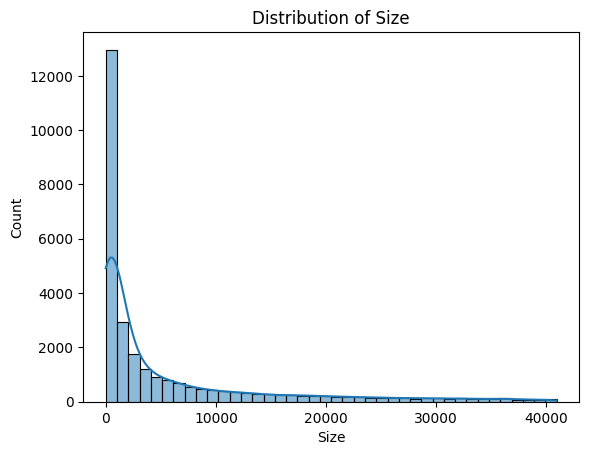

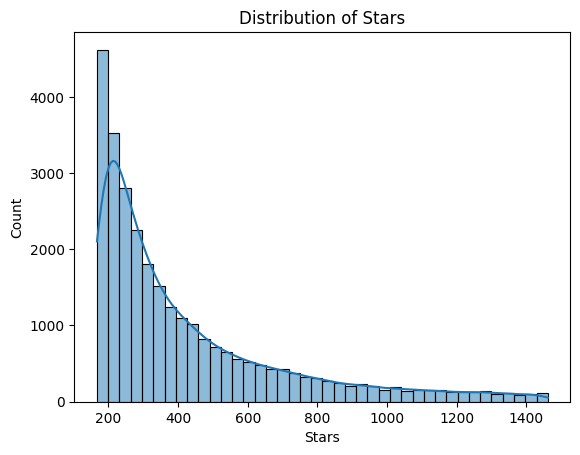

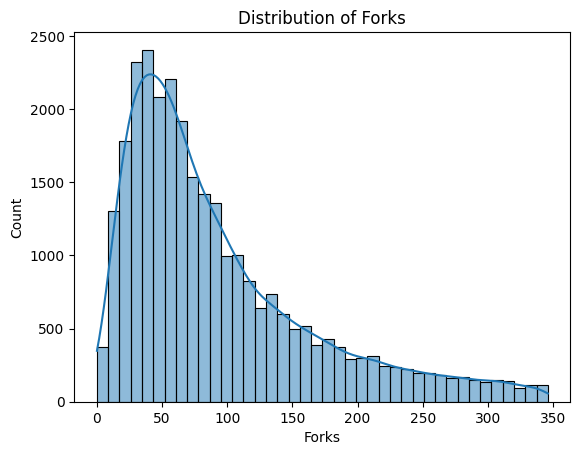

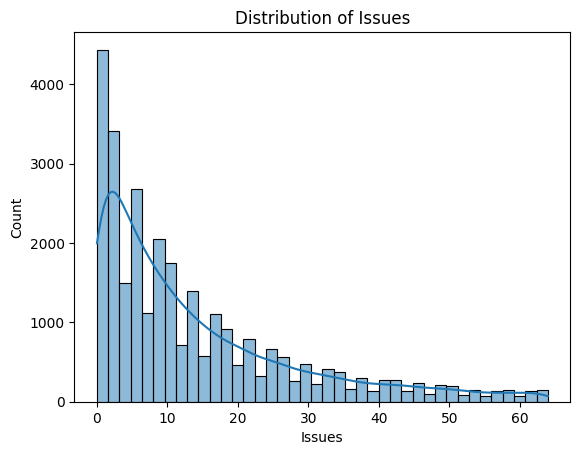

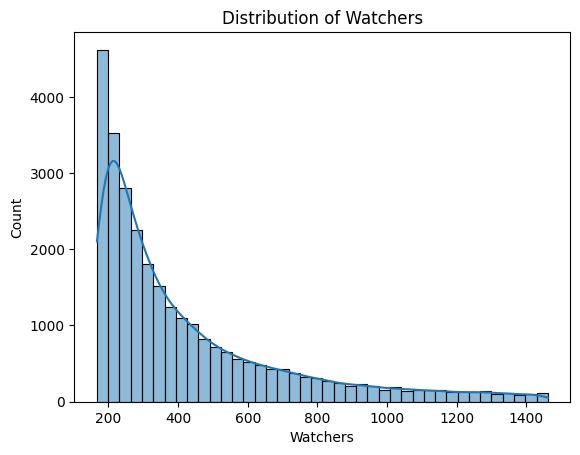

In [ ]:
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

def ignore_outliers(col):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1
  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

def plot_dist(col):
  curr_df = ignore_outliers(col).copy()
  sns.histplot(curr_df[col],bins=40,kde = True)
  plt.title(f"Distribution of {col}")
  plt.show()


for col in (numeric_columns):
    plot_dist(col)

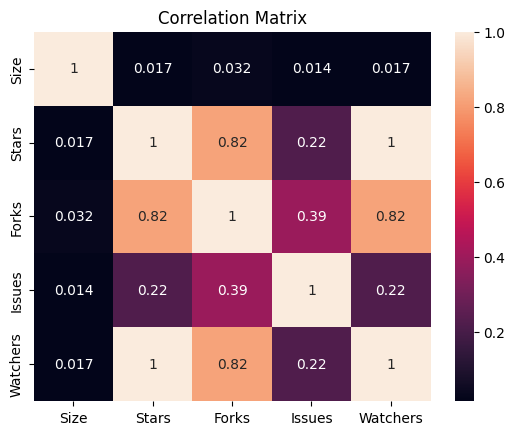

In [ ]:
sns.heatmap(df[numeric_columns].corr(), annot=True)
plt.title("Correlation Matrix")
plt.show()

In [ ]:
print(df[['Stars','Watchers']].corr())

          Stars  Watchers
Stars       1.0       1.0
Watchers    1.0       1.0


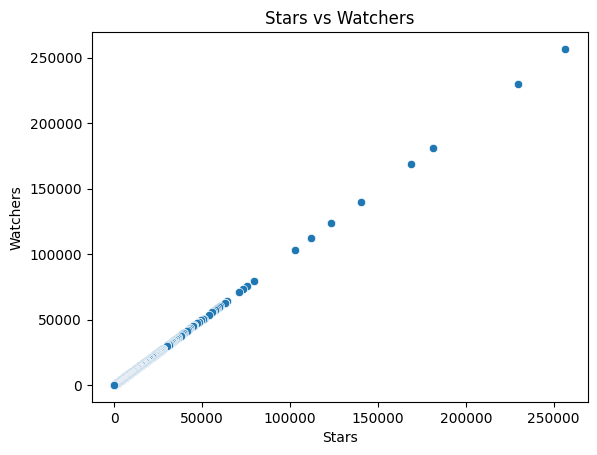

In [ ]:
def scat_plot(col1, col2):
  sns.scatterplot(x=df[col1], y=df[col2])
  plt.title(f"{col1} vs {col2}")
  plt.show()

scat_plot("Stars","Watchers")

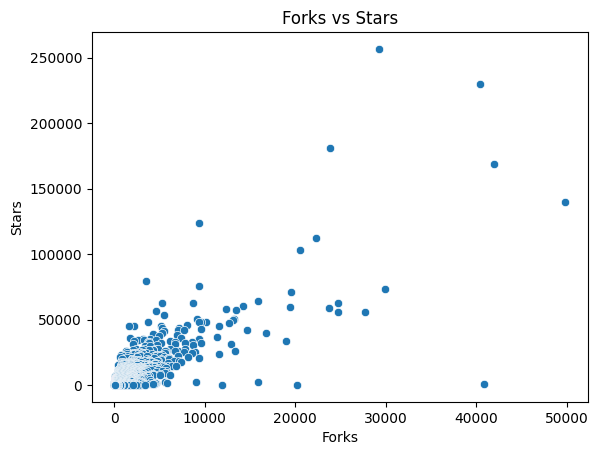

In [ ]:
scat_plot("Forks","Stars")

In [ ]:
df.drop(columns=["Watchers"], inplace=True)

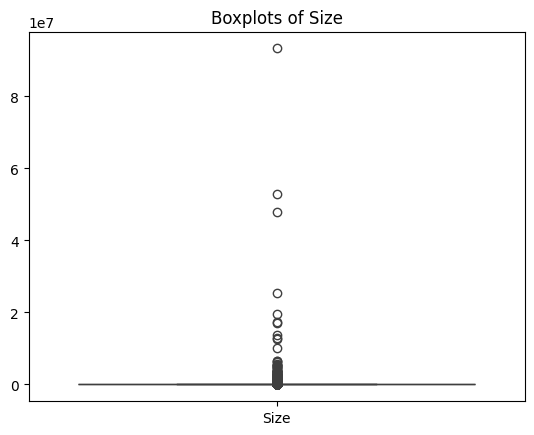

In [ ]:
sns.boxplot(data=df[["Size"]])
plt.title("Boxplots of Size")
plt.show()

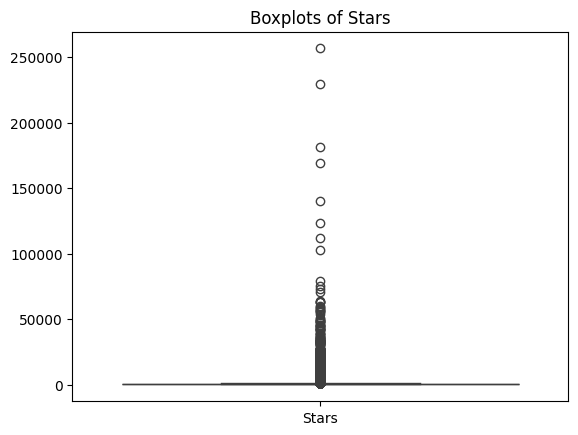

In [ ]:
sns.boxplot(data=df[["Stars"]])
plt.title("Boxplots of Stars")
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32784 entries, 5 to 215027
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Name             32784 non-null  object
 1   Description      31432 non-null  object
 2   URL              32784 non-null  object
 3   Created At       32784 non-null  object
 4   Updated At       32784 non-null  object
 5   Homepage         10235 non-null  object
 6   Size             32784 non-null  int64 
 7   Stars            32784 non-null  int64 
 8   Forks            32784 non-null  int64 
 9   Issues           32784 non-null  int64 
 10  License          26002 non-null  object
 11  Topics           32784 non-null  object
 12  Has Issues       32784 non-null  bool  
 13  Has Projects     32784 non-null  bool  
 14  Has Downloads    32784 non-null  bool  
 15  Has Wiki         32784 non-null  bool  
 16  Has Pages        32784 non-null  bool  
 17  Has Discussions  32784 non-null  bo

In [ ]:
df.head(2).T

,5,7
Name,public-apis,system-design-primer
Description,A collective list of free APIs,Learn how to design large-scale systems. Prep for the system design interview. Includes Anki flashcards.
URL,https://github.com/public-apis/public-apis,https://github.com/donnemartin/system-design-primer
Created At,2016-03-20T23:49:42Z,2017-02-26T16:15:28Z
Updated At,2023-09-21T11:22:06Z,2023-09-21T11:32:17Z
Homepage,http://public-apis.org,NaN
Size,5088,11187
Stars,256615,229569
Forks,29254,40474
Issues,191,393


In [ ]:
df.columns

Index(['Name', 'Description', 'URL', 'Created At', 'Updated At', 'Homepage',
       'Size', 'Stars', 'Forks', 'Issues', 'License', 'Topics', 'Has Issues',
       'Has Projects', 'Has Downloads', 'Has Wiki', 'Has Pages',
       'Has Discussions', 'Is Fork', 'Is Template', 'Default Branch'],
      dtype='object')

In [ ]:
columns_to_keep = [
    "Name", "Description", "URL", "Size", "Stars",
    "Forks", "Issues", "License", "Topics"
]

df[columns_to_keep].head().T

,5,7,11,15,26
Name,public-apis,system-design-primer,awesome-python,Python,Python-100-Days
Description,A collective list of free APIs,Learn how to design large-scale systems. Prep for the system design interview. Includes Anki flashcards.,"A curated list of awesome Python frameworks, libraries, software and resources",All Algorithms implemented in Python,Python - 100天从新手到大师
URL,https://github.com/public-apis/public-apis,https://github.com/donnemartin/system-design-primer,https://github.com/vinta/awesome-python,https://github.com/TheAlgorithms/Python,https://github.com/jackfrued/Python-100-Days
Size,5088,11187,6696,13858,310266
Stars,256615,229569,181326,169000,140142
Forks,29254,40474,23837,41926,49865
Issues,191,393,383,118,691
License,MIT,NOASSERTION,NOASSERTION,MIT,NaN
Topics,"['api', 'apis', 'dataset', 'development', 'free', 'list', 'lists', 'open-source', 'public', 'public-api', 'public-apis', 'resources', 'software']","['design', 'design-patterns', 'design-system', 'development', 'interview', 'interview-practice', 'interview-questions', 'programming', 'python', 'system', 'web', 'web-application', 'webapp']","['awesome', 'collections', 'python', 'python-framework', 'python-library', 'python-resources']","['algorithm', 'algorithm-competitions', 'algorithms-implemented', 'algos', 'community-driven', 'education', 'hacktoberfest', 'interview', 'learn', 'practice', 'python', 'searches', 'sorting-algorithms', 'sorts']",[]


In [ ]:
df["Description"].str.len().describe()

,Description
count,31432.000000
mean,75.350853
std,380.939601
min,2.000000
25%,41.000000
50%,61.000000
75%,88.000000
max,59261.000000


In [ ]:
df[df["Description"].str.len()<4].head()

,Name,Description,URL,Created At,Updated At,Homepage,Size,Stars,Forks,Issues,License,Topics,Has Issues,Has Projects,Has Downloads,Has Wiki,Has Pages,Has Discussions,Is Fork,Is Template,Default Branch
28343,Interview-code-practice-python,面试题,https://github.com/leeguandong/Interview-code-practice-python,2017-12-30T07:51:00Z,2023-09-24T12:09:18Z,NaN,151,1551,586,13,NaN,[],True,True,True,True,False,False,False,False,master
60399,catprinter,🐱🖨,https://github.com/rbaron/catprinter,2021-08-14T07:26:18Z,2023-09-03T22:20:32Z,NaN,3855,705,46,7,MIT,[],True,True,True,True,False,False,False,False,main
115672,TensorExpand,集成包,https://github.com/wucng/TensorExpand,2018-01-04T06:39:31Z,2023-07-01T17:04:37Z,NaN,64871,347,236,16,NOASSERTION,[],True,True,True,True,True,False,False,False,master


In [ ]:
special_chars_regex = r'^[^a-zA-Z0-9]+$'
df[df["Description"].str.contains(special_chars_regex, na=False)].head(3)

,Name,Description,URL,Created At,Updated At,Homepage,Size,Stars,Forks,Issues,License,Topics,Has Issues,Has Projects,Has Downloads,Has Wiki,Has Pages,Has Discussions,Is Fork,Is Template,Default Branch
484,jieba,结巴中文分词,https://github.com/fxsjy/jieba,2012-09-29T07:52:01Z,2023-09-21T09:12:48Z,NaN,56033,31252,6707,665,MIT,[],True,True,True,True,False,False,False,False,master
507,HanLP,中文分词 词性标注 命名实体识别 依存句法分析 成分句法分析 语义依存分析 语义角色标注 指代消解 风格转换 语义相似度 新词发现 关键词短语提取 自动摘要 文本分类聚类 拼音简繁转换 自然语言处理,https://github.com/hankcs/HanLP,2014-10-09T06:36:16Z,2023-09-21T11:24:05Z,https://hanlp.hankcs.com/,72752,30284,8728,10,Apache-2.0,"['dependency-parser', 'hanlp', 'named-entity-recognition', 'natural-language-processing', 'nlp', 'pos-tagging', 'semantic-parsing', 'text-classification']",True,True,True,True,False,False,False,False,doc-zh
2094,YYeTsBot,🎬 人人影视 机器人和网站，包含人人影视全部资源以及众多网友的网盘分享,https://github.com/tgbot-collection/YYeTsBot,2019-08-15T07:50:56Z,2023-09-21T07:26:58Z,https://yyets.dmesg.app,20041,13123,1703,2,MIT,"['bot', 'movies', 'telegram-bot', 'tv-shows', 'yyets', 'zimuxia']",True,True,True,True,False,True,False,False,master


In [ ]:
df[df["Description"].str.len()<10].head()

,Name,Description,URL,Created At,Updated At,Homepage,Size,Stars,Forks,Issues,License,Topics,Has Issues,Has Projects,Has Downloads,Has Wiki,Has Pages,Has Discussions,Is Fork,Is Template,Default Branch
484,jieba,结巴中文分词,https://github.com/fxsjy/jieba,2012-09-29T07:52:01Z,2023-09-21T09:12:48Z,NaN,56033,31252,6707,665,MIT,[],True,True,True,True,False,False,False,False,master
2752,tutorials,机器学习相关教程,https://github.com/MorvanZhou/tutorials,2016-05-29T13:29:44Z,2023-09-21T05:41:19Z,https://morvanzhou.github.io/tutorials,62652,10953,5726,13,MIT,"['machine-learning', 'multiprocessing', 'neural-network', 'numpy', 'python', 'sklearn', 'tensorflow', 'theano', 'threading']",True,True,True,False,False,False,False,False,master
6733,chineseocr,yolo3+ocr,https://github.com/chineseocr/chineseocr,2018-05-01T14:27:52Z,2023-09-21T07:06:00Z,NaN,36625,5519,1712,431,MIT,"['chinese-ocr', 'chinese-text-detect', 'darknet-text-detect', 'idcard', 'ocr', 'opencv-dnn', 'trainticket', 'yolo3']",True,True,True,True,False,False,False,False,app
6916,autocut,用文本编辑器剪视频,https://github.com/mli/autocut,2022-10-28T21:53:27Z,2023-09-21T08:46:43Z,NaN,787,5403,522,22,Apache-2.0,[],True,False,True,False,False,False,False,False,main
8649,Blasting_dictionary,爆破字典,https://github.com/rootphantomer/Blasting_dictionary,2015-05-19T08:55:12Z,2023-09-21T04:44:48Z,NaN,19740,4498,2836,0,NaN,[],True,True,True,True,False,False,False,False,master


In [ ]:
df[(df["Topics"].str.len()<3) & ((df["Description"].str.len()<10) | (df["Description"].str.contains(special_chars_regex)))].head()

,Name,Description,URL,Created At,Updated At,Homepage,Size,Stars,Forks,Issues,License,Topics,Has Issues,Has Projects,Has Downloads,Has Wiki,Has Pages,Has Discussions,Is Fork,Is Template,Default Branch
484,jieba,结巴中文分词,https://github.com/fxsjy/jieba,2012-09-29T07:52:01Z,2023-09-21T09:12:48Z,NaN,56033,31252,6707,665,MIT,[],True,True,True,True,False,False,False,False,master
2158,zhao,【编程随想】整理的《太子党关系网络》，专门揭露赵国的权贵,https://github.com/programthink/zhao,2016-02-28T15:38:57Z,2023-09-21T10:43:52Z,NaN,72400,12899,2807,371,GPL-3.0,[],True,True,True,False,False,False,False,False,master
6413,ChatBotCourse,自己动手做聊天机器人教程,https://github.com/lcdevelop/ChatBotCourse,2016-06-23T01:27:49Z,2023-09-21T07:29:45Z,https://www.lcsays.com,17202,5750,1721,31,MIT,[],True,True,True,True,False,False,False,False,master
6714,lihang_book_algorithm,致力于将李航博士《统计学习方法》一书中所有算法实现一遍,https://github.com/WenDesi/lihang_book_algorithm,2016-07-16T03:28:14Z,2023-09-21T06:23:09Z,http://blog.csdn.net/wds2006sdo/article/category/6314784,24380,5528,2017,12,NaN,[],True,True,True,True,False,False,False,False,master
6880,r0capture,安卓应用层抓包通杀脚本,https://github.com/r0ysue/r0capture,2020-11-29T07:37:06Z,2023-09-21T11:04:30Z,NaN,7565,5422,1233,9,Apache-2.0,[],True,True,True,True,False,False,False,False,main


In [ ]:
df["Description"].str.len().describe()

,Description
count,31432.000000
mean,75.350853
std,380.939601
min,2.000000
25%,41.000000
50%,61.000000
75%,88.000000
max,59261.000000


In [ ]:
df[(df["Description"].str.contains(special_chars_regex) & ~(df["Description"].isna()))].shape

(545, 21)

In [ ]:
clean_df = df[~(df["Description"].str.contains(special_chars_regex) & ~(df["Description"].isna()))].copy()

In [ ]:
clean_df.shape

(32239, 21)

In [ ]:
to_drop = ['Homepage', 'Forks', 'Issues', 'License', 'Has Issues',
       'Has Projects', 'Has Downloads', 'Has Wiki', 'Has Pages',
       'Has Discussions', 'Is Fork', 'Is Template', 'Default Branch']

clean_df.drop(columns=to_drop, inplace=True)

In [ ]:
clean_df[(clean_df["Topics"].str.len()<3) & ((clean_df["Description"].str.len()<10) | (clean_df["Description"].str.contains(special_chars_regex)))].shape

(62, 8)

In [ ]:
clean_df = clean_df[~((clean_df["Topics"].str.len()<3) & (clean_df["Description"].str.len()<10))].copy()

In [ ]:
clean_df[clean_df["Description"].isna()].shape

(1352, 8)

In [ ]:
english = r'^[a-zA-Z]'
check = clean_df.copy()
check.dropna(subset=["Description"],inplace=True)
check.shape

(30825, 8)

In [ ]:
check[check["Description"].str.contains(english)].shape

(27577, 8)

In [ ]:
clean_df = clean_df[(clean_df["Description"].str.contains(english, na=False)) | (clean_df["Description"].isna())]


In [ ]:
clean_df[clean_df["Description"].isna()].shape

(1352, 8)

In [ ]:
no_description_df = clean_df[clean_df["Description"].isna()].copy()


In [ ]:
no_description_df.shape

(1352, 8)

In [ ]:
clean_df[clean_df["Stars"]>300].shape

(16978, 8)

In [ ]:
clean_df["Stars"].describe()

,Stars
count,28929.000000
mean,1005.559300
std,3874.887051
min,167.000000
25%,231.000000
50%,356.000000
75%,716.000000
max,256615.000000


In [ ]:
no_description_df["Stars"].describe()

,Stars
count,1352.000000
mean,560.829142
std,1515.768236
min,167.000000
25%,211.000000
50%,290.000000
75%,468.000000
max,34093.000000


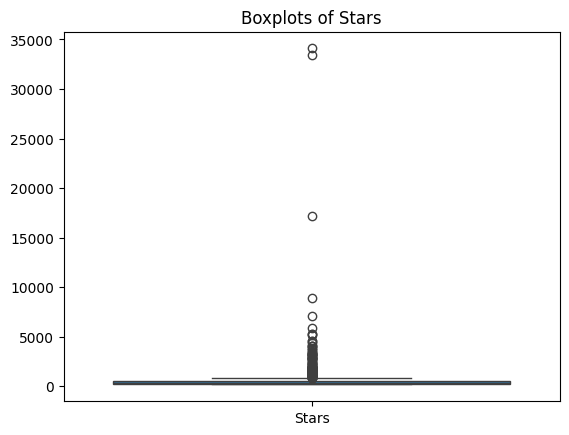

In [ ]:
sns.boxplot(data=no_description_df[["Stars"]])
plt.title("Boxplots of Stars")
plt.show()

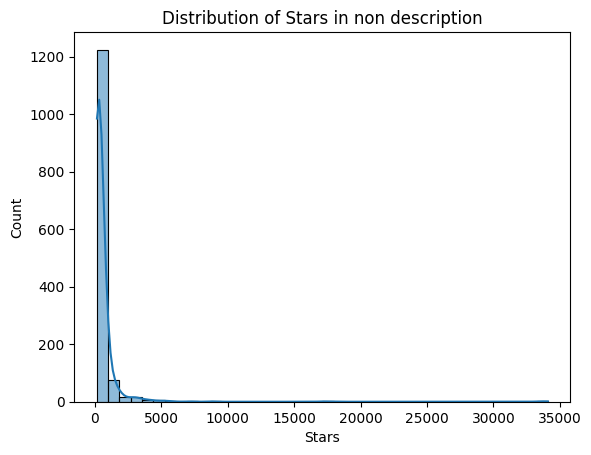

In [ ]:
sns.histplot(no_description_df["Stars"],bins=40,kde = True)
plt.title("Distribution of Stars in non description")
plt.show()

In [ ]:
no_description_df[no_description_df["Topics"].str.len()>3].shape

(94, 8)

In [ ]:
clean_df["Topics"] = clean_df.Topics.apply(lambda x: np.nan if len(str(x))<3 else x)

In [ ]:
clean_df[clean_df["Topics"].isna()].shape

(13017, 8)

In [ ]:
no_Topics_df = clean_df[clean_df["Topics"].isna()].copy()

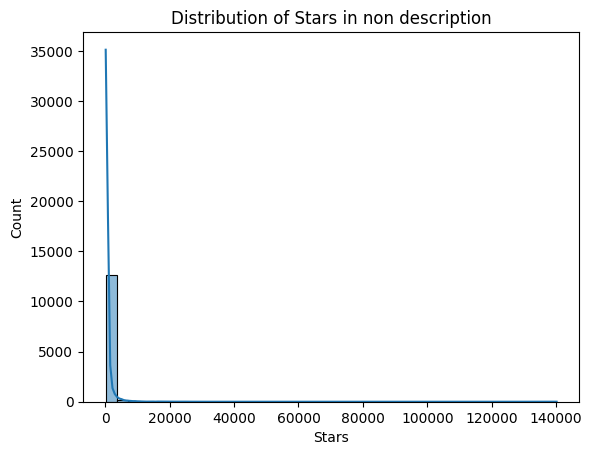

In [ ]:
sns.histplot(no_Topics_df["Stars"],bins=40,kde = True)
plt.title("Distribution of Stars in non description")
plt.show()

In [ ]:
no_Topics_df["Stars"].describe()

,Stars
count,13017.000000
mean,740.802412
std,2496.110225
min,167.000000
25%,221.000000
50%,318.000000
75%,582.000000
max,140142.000000


In [ ]:
clean_df.drop(columns=["Topics","Description"], inplace=False).shape

(28929, 6)

In [ ]:
clean_df["Stars"].describe()

,Stars
count,28929.000000
mean,1005.559300
std,3874.887051
min,167.000000
25%,231.000000
50%,356.000000
75%,716.000000
max,256615.000000


In [ ]:
clean_df.dropna(subset=["Topics","Description"], inplace=False).Stars.describe()

,Stars
count,15818.000000
mean,1226.254331
std,4714.110445
min,167.000000
25%,244.250000
50%,398.000000
75%,850.750000
max,256615.000000


Data Note:  
Before filtering, the average number of stars is very high (mean of 1005), indicating popularity and success. After filtering, the dataset size is reduced, but the average number of stars increased (1226), meaning we are left with relatively more popular projects.

Next Steps:  
Removing projects with empty descriptions or empty topics:  
This allows us to focus only on projects with meaningful descriptions or topics, which can provide additional information about the project.  
This filtering also improves the quality of the data since we retain projects with useful information.

In [ ]:
clean_df.dropna(subset=["Topics","Description"], inplace=True)

In [ ]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15818 entries, 5 to 215013
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         15818 non-null  object
 1   Description  15818 non-null  object
 2   URL          15818 non-null  object
 3   Created At   15818 non-null  object
 4   Updated At   15818 non-null  object
 5   Size         15818 non-null  int64 
 6   Stars        15818 non-null  int64 
 7   Topics       15818 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.1+ MB


In [ ]:
clean_df[["Description","Topics"]].head(20)

,Description,Topics
5,A collective list of free APIs,"['api', 'apis', 'dataset', 'development', 'free', 'list', 'lists', 'open-source', 'public', 'public-api', 'public-apis', 'resources', 'software']"
7,Learn how to design large-scale systems. Prep for the system design interview. Includes Anki flashcards.,"['design', 'design-patterns', 'design-system', 'development', 'interview', 'interview-practice', 'interview-questions', 'programming', 'python', 'system', 'web', 'web-application', 'webapp']"
11,"A curated list of awesome Python frameworks, libraries, software and resources","['awesome', 'collections', 'python', 'python-framework', 'python-library', 'python-resources']"
15,All Algorithms implemented in Python,"['algorithm', 'algorithm-competitions', 'algorithms-implemented', 'algos', 'community-driven', 'education', 'hacktoberfest', 'interview', 'learn', 'practice', 'python', 'searches', 'sorting-algorithms', 'sorts']"
43,Stable Diffusion web UI,"['ai', 'ai-art', 'deep-learning', 'diffusion', 'gradio', 'image-generation', 'image2image', 'img2img', 'pytorch', 'stable-diffusion', 'text2image', 'torch', 'txt2img', 'unstable', 'upscaling', 'web']"
66,Magnificent app which corrects your previous console command.,"['python', 'shell']"
77,The Web framework for perfectionists with deadlines.,"['apps', 'django', 'framework', 'models', 'orm', 'python', 'templates', 'views', 'web']"
88,Tensors and Dynamic neural networks in Python with strong GPU acceleration,"['autograd', 'deep-learning', 'gpu', 'machine-learning', 'neural-network', 'numpy', 'python', 'tensor']"
106,The Python micro framework for building web applications.,"['flask', 'jinja', 'pallets', 'python', 'web-framework', 'werkzeug', 'wsgi']"
113,"FastAPI framework, high performance, easy to learn, fast to code, ready for production","['api', 'async', 'asyncio', 'fastapi', 'framework', 'json', 'json-schema', 'openapi', 'openapi3', 'pydantic', 'python', 'python-types', 'python3', 'redoc', 'rest', 'starlette', 'swagger', 'swagger-ui', 'uvicorn', 'web']"


In [ ]:
#clean_df.to_excel("/content/drive/MyDrive/GitHubRepositoriesProject/clean_df.xlsx", index=False)

# Frequent Words

In [ ]:
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [ ]:
clean_df = pd.read_excel("/content/drive/MyDrive/GitHubRepositoriesProject/clean_df.xlsx")

In [ ]:
clean_df.at[1, 'Topics']

"['design', 'design-patterns', 'design-system', 'development', 'interview', 'interview-practice', 'interview-questions', 'programming', 'python', 'system', 'web', 'web-application', 'webapp']"

In [ ]:
def clean_text(text):

  cleaned_text = text.replace("'","").replace("-"," ").replace("_"," ")
  cleaned_text = cleaned_text.lower().strip()
  cleaned_text = re.sub(r"[\[\]]", "", cleaned_text)
  cleaned_text = cleaned_text.replace("python","")
  cleaned_text = re.sub(r'[^a-zA-Z0-9,\s]', '', cleaned_text)
  cleaned_text = re.sub(r'\b\d+\b', '', cleaned_text)
  cleaned_text = re.sub(r',\s+', ',', cleaned_text)
  cleaned_text = re.sub(r',+', ', ', cleaned_text)

  return cleaned_text if len(cleaned_text)>1 else ""

clean_df["Description"] = clean_df["Description"].apply(clean_text)
clean_df['Topics'] = clean_df['Topics'].apply(clean_text)

In [ ]:
clean_df.at[1, 'Topics']

'design, design patterns, design system, development, interview, interview practice, interview questions, programming, system, web, web application, webapp'

In [ ]:
english = r'^[a-zA-Z]+$'

english_stop_words = set(ENGLISH_STOP_WORDS)
english_stop_words.update(['using','use', 'based', 'library', 'tool', 'python','paper','create'])

def remove_stop_words(text):
    words = text.lower().split()
    filtered_words = [word for word in words if word not in english_stop_words]
    final_words = [word for word in filtered_words if re.fullmatch(english, word)]

    return ' '.join(final_words) if final_words else ''

clean_df = clean_df.copy()
clean_df['Description'] = clean_df['Description'].apply(remove_stop_words)

all_descriptions_words = ' '.join(clean_df['Description'].apply(remove_stop_words))
all_descriptions_words

'collective list free apis learn design large scale systems prep design interview includes anki flashcards curated list awesome software resources algorithms implemented stable diffusion web ui magnificent app corrects previous console command web framework perfectionists deadlines tensors dynamic neural networks strong gpu acceleration micro framework building web applications fastapi high easy fast ready production deep learning humans ansible radically simple automation platform makes applications systems easier deploy maintain automate code deployment network configuration cloud language approaches plain agents install remote systems httpsdocsansiblecom virtualization devops interview questions youtube dl fork additional features fixes scikit learn machine learning animation engine explanatory math videos list useful payloads bypass web application security pentestctf http worlds simplest facial recognition api command line fast high level web crawling scraping framework deepfakes 

In [ ]:
topics_words = clean_df['Topics'].copy().apply(
    lambda topic: ','.join(
        [re.sub(r'[^a-zA-Z0-9\s\n-]'," ", word.replace("-"," ")) for word in topic.split(",")]
    )
)
# clean_df['Topics'] = clean_df['Topics'].apply(remove_stop_words)

all_topics_words = ','.join(topics_words)
all_topics_words = all_topics_words.strip()
all_topics_words = re.sub(r',\s+', ', ', all_topics_words)

In [ ]:
all_topics_words

'api, apis, dataset, development, free, list, lists, open source, public, public api, public apis, resources, software,design, design patterns, design system, development, interview, interview practice, interview questions, programming, system, web, web application, webapp,awesome, collections, framework, library, resources,algorithm, algorithm competitions, algorithms implemented, algos, community driven, education, hacktoberfest, interview, learn, practice, searches, sorting algorithms, sorts,ai, ai art, deep learning, diffusion, gradio, image generation, image2image, img2img, pytorch, stable diffusion, text2image, torch, txt2img, unstable, upscaling, web,, shell,apps, django, framework, models, orm, templates, views, web,autograd, deep learning, gpu, machine learning, neural network, numpy, tensor,flask, jinja, pallets, web framework, werkzeug, wsgi,api, async, asyncio, fastapi, framework, json, json schema, openapi, openapi3, pydantic, types, redoc, rest, starlette, swagger, swagge

In [ ]:
clean_df.at[1, 'Topics']

'design, design patterns, design system, development, interview, interview practice, interview questions, programming, system, web, web application, webapp'

In [ ]:
wordcloud_des = WordCloud(width=800, height=400, background_color='white').generate(all_descriptions_words)

In [ ]:
wordcloud_topics = WordCloud(width=800, height=400, background_color='white').generate(all_topics_words)

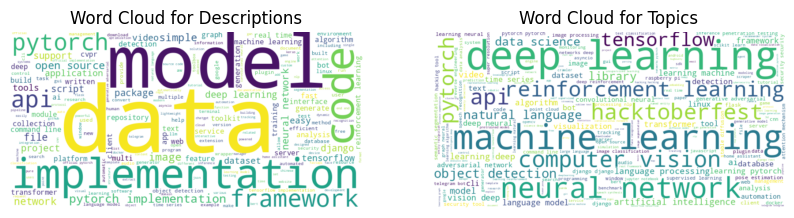

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_des, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Descriptions')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_topics, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Topics')
plt.show()

In [ ]:
# Counter(all_descriptions_words.split()).most_common(10)

In [ ]:
Counter(word for word in all_topics_words.split(", ") if word.strip()).most_common(10)

[('deep learning', 1364),
 ('pytorch', 1292),
 ('machine learning', 1266),
 ('hacktoberfest', 533),
 ('nlp', 398),
 ('tensorflow', 383),
 ('computer vision', 329),
 ('security', 291),
 ('linux', 284),
 ('keras', 259)]

# Check Overlap

In [ ]:
clean_df[["Description","Topics"]].fillna("", inplace=True)

<ipython-input-17-716eb680b059>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[["Description","Topics"]].fillna("", inplace=True)


In [ ]:
clean_df = clean_df.copy()
clean_df['Description'] = clean_df['Description'].fillna("")
clean_df['Topics'] = clean_df['Topics'].fillna("")

all_texts = pd.concat([clean_df['Description'], clean_df['Topics']])

vectorizer = CountVectorizer()
vectorizer.fit(all_texts)

description_matrix = vectorizer.transform(clean_df['Description'])

topics_matrix = vectorizer.transform(clean_df['Topics'])

def calculate_overlap(description_matrix, topics_matrix, features):
    overlap_scores = []
    common_words_list = []

    for i in range(description_matrix.shape[0]):
        description_vec = description_matrix[i].toarray().flatten()
        topics_vec = topics_matrix[i].toarray().flatten()

        common_indices = np.where((description_vec > 0) & (topics_vec > 0))[0]

        overlap_score = np.sum(topics_vec[common_indices])

        common_words = [features[idx] for idx in common_indices]

        overlap_scores.append(overlap_score)
        common_words_list.append(common_words)

    return overlap_scores, common_words_list

overlap_scores, common_words_list = calculate_overlap(description_matrix, topics_matrix, vectorizer.get_feature_names_out())

clean_df['Overlap_Score'] = overlap_scores
clean_df['Common_Words'] = common_words_list



In [ ]:
clean_df.sort_values(by="Overlap_Score", ascending=False, inplace=True)

In [ ]:
clean_df.head(10).T

,7262,198,8332,9158,1252,10591,722,7593,6563,14002
Name,PyPOTS,changedetection.io,swarmlib,instagrapi-rest,scrapydweb,accel-brain-code,quant-trading,Object_Detection_Tracking,hftbacktest,jetson
Description,toolboxlibrary data mining partially observed ...,best simplest free open source website change ...,repository implements swarm optimization algor...,restful api wrapper instagram private api,web app scrapyd cluster scrapy log analysis au...,purpose repository make prototypes case study ...,quantitative trading strategies including vix ...,box code models cmus object detection tracking...,high frequency trading market making backtesti...,helmut hoffer von ankershoffen experimenting n...
URL,https://github.com/WenjieDu/PyPOTS,https://github.com/dgtlmoon/changedetection.io,https://github.com/HaaLeo/swarmlib,https://github.com/subzeroid/instagrapi-rest,https://github.com/my8100/scrapydweb,https://github.com/accel-brain/accel-brain-code,https://github.com/je-suis-tm/quant-trading,https://github.com/JunweiLiang/Object_Detectio...,https://github.com/nkaz001/hftbacktest,https://github.com/helmut-hoffer-von-ankershof...
Created At,2022-03-29T14:22:47Z,2021-01-27T16:03:30Z,2018-11-04T16:47:18Z,2021-03-15T10:01:47Z,2018-09-30T19:11:44Z,2017-09-15T23:37:39Z,2018-04-03T14:08:14Z,2019-05-26T21:23:44Z,2022-08-25T14:56:36Z,2019-07-04T14:04:04Z
Updated At,2023-09-25T04:20:18Z,2023-09-21T11:00:40Z,2023-09-20T12:39:17Z,2023-09-23T10:20:03Z,2023-09-24T04:19:48Z,2023-09-12T07:46:55Z,2023-09-21T09:44:39Z,2023-09-22T07:59:11Z,2023-09-25T14:38:09Z,2023-09-16T14:14:14Z
Size,7812,6801,201738,127,3196,103037,13119,45599,11100,804
Stars,438,11908,373,333,2817,281,4468,417,492,197
Topics,"classification, clustering, data mining, forec...","back in stock, change alert, change detection,...","aco, ant colony optimization, artificial bee c...","instagram, instagram api, instagram bot, insta...","dashboard, log analysis, log parsing, scrapy, ...","auto encoder, automatic summarization, combina...","algorithmic trading, bollinger bands, commodit...","activity detection, computer vision, deep lear...","algorithmic trading, algotrading, backtesting,...","ansible, archiconda, cuda, docker, edge device..."
Overlap_Score,37,27,25,25,24,24,24,22,21,21
Common_Words,"[data, forecasting, incomplete, irregularly, m...","[change, defacement, detection, monitor, notif...","[algorithm, algorithms, ant, artificial, bee, ...","[api, instagram, private]","[analysis, cluster, log, monitor, scrapy, scra...","[adversarial, auto, deep, energy, learning, ma...","[bollinger, commodity, macd, options, pair, qu...","[camera, detection, efficientdet, multi, objec...","[backtesting, data, frequency, high, limit, ma...","[ankershoffen, cuda, devices, edge, hoffer, io..."


In [ ]:
clean_df.tail(10).T

,2045,13839,15788,15798,48,52,58,63,64,69
Name,SigThief,haoide,Meta-TTS,GPT-Automator,fairseq,stanford_alpaca,python-fire,jax,numpy,glances
Description,stealing signatures making invalid signature time,stop features delivered httpsgithubcomxjsender...,official repository date code refactor branch,voice controlled mac assistant,facebook ai research sequence sequence toolkit...,code documentation train stanfords alpaca gene...,automatically generating command line interfac...,composable transformations numpy programs jit,fundamental package scientific computing,glances eye tophtop alternative mac os windows...
URL,https://github.com/secretsquirrel/SigThief,https://github.com/xjsender/haoide,https://github.com/SungFeng-Huang/Meta-TTS,https://github.com/chidiwilliams/GPT-Automator,https://github.com/facebookresearch/fairseq,https://github.com/tatsu-lab/stanford_alpaca,https://github.com/google/python-fire,https://github.com/google/jax,https://github.com/numpy/numpy,https://github.com/nicolargo/glances
Created At,2017-09-01T20:35:48Z,2015-01-18T10:40:07Z,2021-06-01T09:00:43Z,2023-02-11T11:46:30Z,2017-08-29T16:26:12Z,2023-03-10T23:33:09Z,2017-02-21T21:35:07Z,2018-10-25T21:25:02Z,2010-09-13T23:02:39Z,2011-12-04T08:49:15Z
Updated At,2023-09-25T05:23:42Z,2023-08-08T13:16:00Z,2023-09-16T07:28:56Z,2023-09-20T19:33:21Z,2023-09-21T09:59:09Z,2023-09-21T11:18:51Z,2023-09-21T08:47:20Z,2023-09-21T10:43:18Z,2023-09-21T08:47:44Z,2023-09-21T10:53:19Z
Size,33,7988,11768,1622,25631,8654,6468,71579,130943,38830
Stars,1727,200,167,167,27510,26786,25243,24642,24540,23515
Topics,"certificates, pe, testing antivirus","apex, completion, lightning, lwc, oauth2 login...","deep learning, few shot learning, meta learnin...","automator, gpt , langchain, macos","artificial intelligence, pytorch","deep learning, instruction following, language...","cli,",jax,"numpy,","monitoring, multi platform, restful, restful a..."
Overlap_Score,0,0,0,0,0,0,0,0,0,0
Common_Words,[],[],[],[],[],[],[],[],[],[]


In [ ]:
clean_df.to_excel("/content/drive/MyDrive/GitHubRepositoriesProject/clean_df.xlsx", index=False)

In [ ]:
Counter(word for word in all_topics_words.split(", ") if word.strip()).most_common(50)

[('deep learning', 1364),
 ('pytorch', 1292),
 ('machine learning', 1266),
 ('hacktoberfest', 533),
 ('nlp', 398),
 ('tensorflow', 383),
 ('computer vision', 329),
 ('security', 291),
 ('linux', 284),
 ('keras', 259),
 ('django', 258),
 ('object detection', 250),
 ('natural language processing', 249),
 ('data science', 244),
 ('neural network', 225),
 ('docker', 225),
 ('reinforcement learning', 207),
 ('hacking', 174),
 ('library', 157),
 ('deep neural networks', 157),
 ('llm', 152),
 ('flask', 145),
 ('neural networks', 144),
 ('pentesting', 138),
 ('gan', 137),
 ('gpt ', 134),
 ('osint', 130),
 ('generative adversarial network', 128),
 ('asyncio', 124),
 ('opencv', 123),
 ('image processing', 111),
 ('convolutional neural networks', 108),
 ('penetration testing', 105),
 ('pandas', 105),
 ('chatgpt', 104),
 ('cli', 102),
 ('openai', 101),
 ('numpy', 99),
 ('language model', 98),
 ('dataset', 97),
 ('image classification', 97),
 ('kubernetes', 96),
 ('segmentation', 96),
 ('gui', 95),

In [5]:
clean_df.columns

Index(['Name', 'Description', 'URL', 'Created At', 'Updated At', 'Size',
       'Stars', 'Topics', 'Overlap_Score', 'Common_Words'],
      dtype='object')

In [12]:
clean_df.at[0,'Created At']

'2022-03-29T14:22:47Z'

In [27]:
clean_df['Created At'] = pd.to_datetime(clean_df['Created At'], format='%Y-%m-%dT%H:%M:%SZ', utc=True).dt.tz_localize(None)
clean_df["Updated At"] = pd.to_datetime(clean_df["Updated At"], format='%Y-%m-%dT%H:%M:%SZ', utc=True).dt.tz_localize(None)

In [35]:
clean_df["Year"] = clean_df["Created At"].dt.year
year_distribution = clean_df["Year"].value_counts().sort_index()
year_distribution

,count
Year,
2008,8
2009,55
2010,113
2011,241
2012,352
2013,494
2014,701
2015,853
2016,1290


Text(0.5, 1.0, 'Number of Projects per Year')

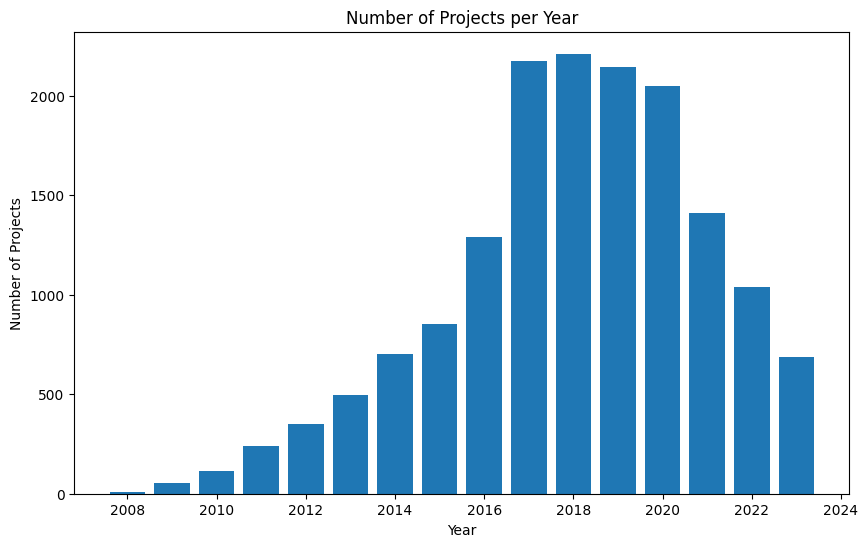

In [32]:
plt.figure(figsize=(10, 6))
plt.bar(year_distribution.index, year_distribution.values, )
plt.xlabel('Year')
plt.ylabel('Number of Projects')
plt.title('Number of Projects per Year')

In [39]:
clean_df = clean_df[clean_df["Year"]> 2016]
clean_df.to_excel("/content/drive/MyDrive/GitHubRepositoriesProject/clean_df.xlsx", index=False)